In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind
import uncertainties as unc
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
# Ensure plots are shown in Jupyter notebook
%matplotlib inline


overview = pd.read_excel("Data/overview.xlsx", header=1, sheet_name="Magnetic Heart Vektor OX_(x y)")

positive_data_T = overview[overview["ARVC"] == "ja"][["Area", "T_Dist", "Compact", "Angle"]].dropna(axis=0, how="all")
negative_data_T = overview[overview["ARVC"] == "nein"][["Area", "T_Dist", "Compact", "Angle"]].dropna(axis=0, how="all")

positive_data_R_T_max = overview[overview["ARVC"] == "ja"][["Area.1", "T_Dist.1", "Compact.1", "Angle.1"]].dropna(axis=0, how="all")
negative_data_R_T_max = overview[overview["ARVC"] == "nein"][["Area.1", "T_Dist.1", "Compact.1", "Angle.1"]].dropna(axis=0, how="all")


In [18]:



def remove_outliers_iqr(data):
    """
    Remove outliers from data using the Interquartile Range (IQR) method.
    
    Parameters:
    data (array-like): Input data array
    
    Returns:
    array: Data with outliers removed
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return data[(data >= lower) & (data <= upper)]


def perform_t_test(data1, data2, name="", hypothesis="data1_greater", threshold=None, labels=("Group 1", "Group 2")):
    """
    Perform a t-test on two datasets with flexible hypothesis direction.
    
    Parameters:
    data1 (array-like): First dataset
    data2 (array-like): Second dataset
    name (str): Name used in the plot titles and output messages
    hypothesis (str): Direction of the hypothesis test:
                    "data1_greater" - one-tailed test where data1 > data2 (default)
                    "data2_greater" - one-tailed test where data2 > data1
                    "not_equal" - two-tailed test where data1 != data2
    threshold (float): Optional threshold for visualization
                      to indicate the optimal threshold in the boxplot
                      for the two datasets.
    labels (tuple): Labels for the two groups in the boxplot
    
    Returns:
    tuple: (t_stat, p_value, significant)
    """
    # Clean the data by removing outliers
    data1_clean = remove_outliers_iqr(data1)
    data2_clean = remove_outliers_iqr(data2)
    
    # Print cleaned data statistics
    print(f"Cleaned {name} data 1:", unc.ufloat(np.mean(data1_clean), np.std(data1_clean)))
    print(f"Cleaned {name} data 2:", unc.ufloat(np.mean(data2_clean), np.std(data2_clean)))
    
    # Perform t-test (Welch's t-test with equal_var=False for unequal variances)
    t_stat, p_value_two_tailed = ttest_ind(data1_clean, data2_clean, equal_var=False)
    
    # Set labels based on hypothesis
    if hypothesis == "data1_greater":
        group1_label, group2_label = f'{labels[0]} (Higher)', f'{labels[1]} (Lower)'
        # Convert to one-tailed p-value (data1 > data2)
        p_value = p_value_two_tailed / 2 if t_stat > 0 else 1 - (p_value_two_tailed / 2)
        hypothesis_text = "data1 > data2"
    elif hypothesis == "data2_greater":
        group1_label, group2_label = f'{labels[0]} (Lower)', f'{labels[1]} (Higher)'
        # Convert to one-tailed p-value (data1 < data2)
        p_value = p_value_two_tailed / 2 if t_stat < 0 else 1 - (p_value_two_tailed / 2)
        hypothesis_text = "data1 < data2"
    else:  # "not_equal"
        group1_label, group2_label = labels[0], labels[1]
        p_value = p_value_two_tailed
        hypothesis_text = "data1 ≠ data2"
    
    # Print t-statistic and p-value
    print(f"Hypothesis: {hypothesis_text}")
    print("T-statistic:", t_stat)
    
    if hypothesis == "not_equal":
        print("Two-tailed p-value:", p_value)
    else:
        print("One-tailed p-value:", p_value)
    
    # Check significance (p-value < 0.05)
    significant = p_value < 0.05
    if significant:
        print(f"The result is statistically significant (p-value = {p_value:.4f})")
    else:
        print(f"The result is not statistically significant (p-value = {p_value:.4f})")
    
    # Plot the t-distribution and shade the area for p-value
    df = len(data1_clean) + len(data2_clean) - 2  # degrees of freedom
    
    # Generate a range of x values for the t-distribution
    x = np.linspace(-4, 4, 1000)
    y = t.pdf(x, df)
    
    # Plot the t-distribution
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="t-distribution", color='blue')
    
    # Shade the area corresponding to the p-value
    if hypothesis == "data1_greater":
        plt.fill_between(x, 0, y, where=(x > t_stat), color='red', alpha=0.5, 
                        label=f'p-value Area (t > {t_stat:.2f})')
    elif hypothesis == "data2_greater":
        plt.fill_between(x, 0, y, where=(x < t_stat), color='red', alpha=0.5, 
                        label=f'p-value Area (t < {t_stat:.2f})')
    else:  # "not_equal" - two-tailed
        plt.fill_between(x, 0, y, where=(x > abs(t_stat)) | (x < -abs(t_stat)), color='red', alpha=0.5,
                        label=f'p-value Area (|t| > {abs(t_stat):.2f})')
    
    # Add labels and title
    plt.axvline(x=t_stat, color='green', linestyle='--', label=f't-statistic: {t_stat:.2f}')
    plt.xlabel("t-value")
    plt.ylabel("Probability Density")
    plt.title(f"t-Distribution with Shaded p-value Area ({hypothesis_text})")
    plt.legend()
    plt.show()
    
    # Visualize the cleaned data distributions with boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=[data1_clean, data2_clean], palette=["green", "red"])
    plt.xticks([0, 1], [group1_label, group2_label])
    plt.title(f"Boxplot of Cleaned Data for {name}")

    if threshold is not None:
        plt.axhline(y=threshold, color='orange', linestyle='--', label=f'Optimal Threshold: {threshold}')
        plt.legend()
    
    plt.show()
    
    return t_stat, p_value, significant


def determine_optimal_threshold(data1, data2, hypothesis="data2_greater", labels=("Class 0", "Class 1")):
    """
    Determine the optimal threshold to separate two classes of data.
    
    Parameters:
    data1 (array-like): Data for first class (class 0 by default)
    data2 (array-like): Data for second class (class 1 by default)
    hypothesis (str): The relationship between the data:
                    "data1_greater" - data1 values tend to be higher than data2
                    "data2_greater" - data2 values tend to be higher than data1 (default)
                    "not_equal" - no assumption about which has higher values
                                (will use the mean of each group to determine)
    labels (tuple): Labels for the two classes in the plots
    
    Returns:
    tuple: (optimal_threshold, sensitivity, specificity, f1)
    """
    # Remove outliers using IQR method
    data1_clean = remove_outliers_iqr(data1)
    data2_clean = remove_outliers_iqr(data2)
    
    # Create the scores array by concatenating the data
    y_scores = np.concatenate((data1_clean, data2_clean))
    
    # Determine which class should have higher values based on hypothesis
    invert_scores = False
    display_labels = list(labels)  # Make a copy to avoid modifying the original
    
    if hypothesis == "data1_greater":
        # data1 -> class 1 (positive, higher values), data2 -> class 0 (negative, lower values)
        y_true = np.concatenate((np.ones(len(data1_clean)), np.zeros(len(data2_clean))))
        display_labels = [labels[1], labels[0]]  # Swap labels for plotting
    elif hypothesis == "data2_greater":
        # data1 -> class 0 (negative, lower values), data2 -> class 1 (positive, higher values)
        y_true = np.concatenate((np.zeros(len(data1_clean)), np.ones(len(data2_clean))))
    else:  # "not_equal"
        # Automatically determine which dataset has higher values based on means
        mean1 = np.mean(data1_clean)
        mean2 = np.mean(data2_clean)
        
        if mean1 > mean2:
            # data1 -> class 1 (positive, higher values), data2 -> class 0 (negative, lower values)
            y_true = np.concatenate((np.ones(len(data1_clean)), np.zeros(len(data2_clean))))
            display_labels = [labels[1], labels[0]]  # Swap labels for plotting
            print("Automatic arrangement: data1 values are higher (class 1), data2 values are lower (class 0)")
        else:
            # data1 -> class 0 (negative, lower values), data2 -> class 1 (positive, higher values)
            y_true = np.concatenate((np.zeros(len(data1_clean)), np.ones(len(data2_clean))))
            print("Automatic arrangement: data1 values are lower (class 0), data2 values are higher (class 1)")
    
    # If we need to invert scores for ROC curve calculation
    if invert_scores:
        y_scores = -y_scores
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Calculate Youden Index for each threshold
    youden_index = tpr - fpr
    
    # Find the optimal threshold (the one with the maximum Youden Index)
    optimal_threshold_index = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_threshold_index]
    
    # Print the optimal threshold and Youden index
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Maximum Youden Index: {youden_index[optimal_threshold_index]}")
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot(fpr[optimal_threshold_index], tpr[optimal_threshold_index], 'ro', label='Optimal Threshold')
    
    # Plot diagonal line (chance level)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Convert continuous predictions to binary using the optimal threshold
    y_pred = (y_scores >= optimal_threshold).astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix to percentage
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot confusion matrix in percentage
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=display_labels, yticklabels=display_labels)
    plt.title("Confusion Matrix (Percentage)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Calculate the F1 score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.2f}")
    
    # Calculate the sensitivity and specificity
    sensitivity = np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_true == 1)
    specificity = np.sum((y_pred == 0) & (y_true == 0)) / np.sum(y_true == 0)
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    
    return optimal_threshold, sensitivity, specificity, f1

## Analyze t segment area

Area positive: [0.036 1.295 4.441 0.872 0.381 0.565 0.144]
Area negative: [ 0.978  4.648 10.233  4.485  1.893  3.968  5.133  3.97   0.512]
Optimal Threshold: 1.893
Maximum Youden Index: 0.75


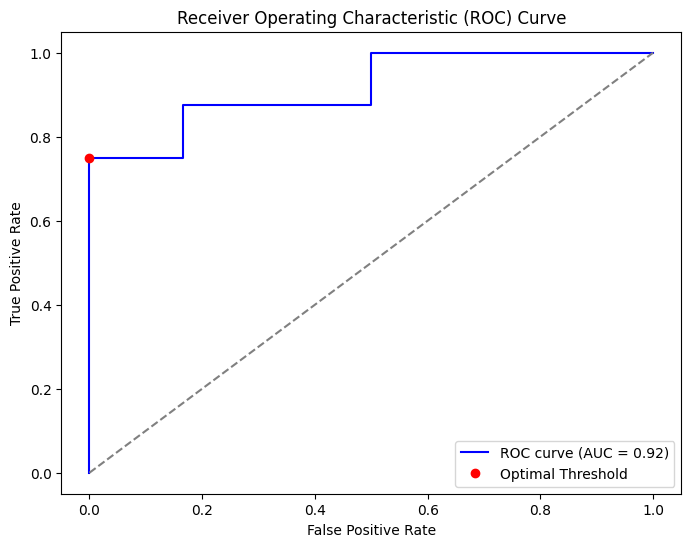

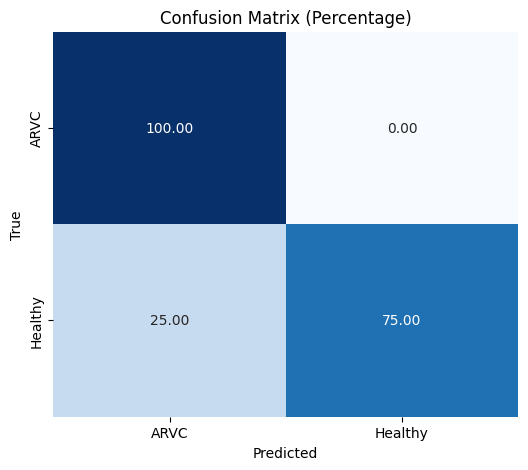

F1 Score: 0.86
Sensitivity: 0.75
Specificity: 1.00
Cleaned Area data 1: 0.5+/-0.4
Cleaned Area data 2: 3.2+/-1.7
Hypothesis: data1 < data2
T-statistic: -3.9957806223696695
One-tailed p-value: 0.0018635648320386266
The result is statistically significant (p-value = 0.0019)


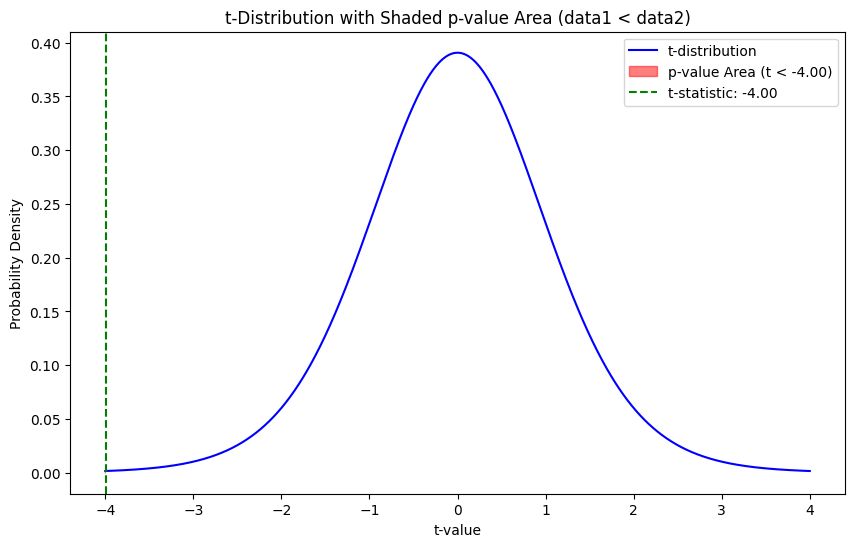

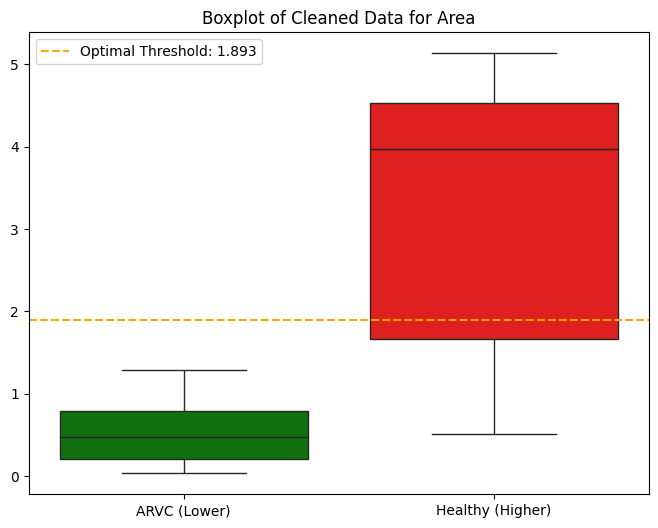

(-3.9957806223696695, 0.0018635648320386266, True)

In [20]:
area_positive = positive_data_T["Area"].values
area_negative = negative_data_T["Area"].values

print("Area positive:", area_positive)
print("Area negative:", area_negative)


optimal_threshold, _, _, _ = determine_optimal_threshold(area_positive, area_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"))


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(area_positive, area_negative, name="Area", hypothesis="data2_greater", threshold=optimal_threshold, labels=("ARVC", "Healthy"))



## Analyze T segment Compact

Compact positive: [0.0071 0.015  0.0166 0.0191 0.0088 0.0212 0.0173]
Compact negative: [0.1329 0.1156 0.1887 0.0537 0.022  0.0133 0.0117 0.0166 0.0243]
Optimal Threshold: 0.022
Maximum Youden Index: 0.6666666666666666


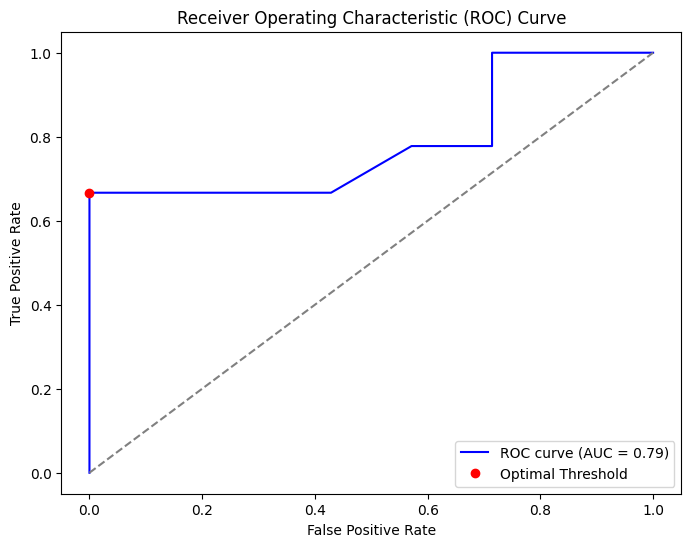

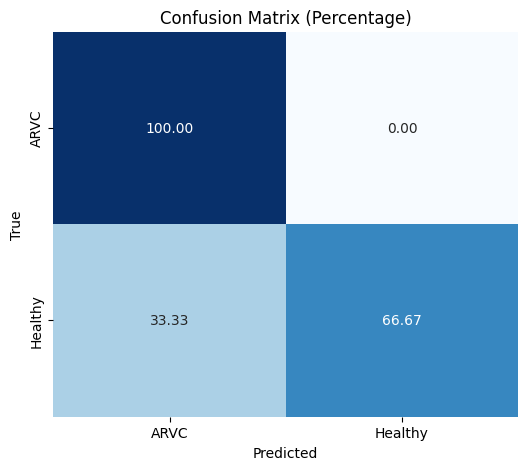

F1 Score: 0.80
Sensitivity: 0.67
Specificity: 1.00
Cleaned Compact data 1: 0.015+/-0.005
Cleaned Compact data 2: 0.06+/-0.06
Hypothesis: data1 < data2
T-statistic: -2.260612705719152
One-tailed p-value: 0.02657500121601118
The result is statistically significant (p-value = 0.0266)


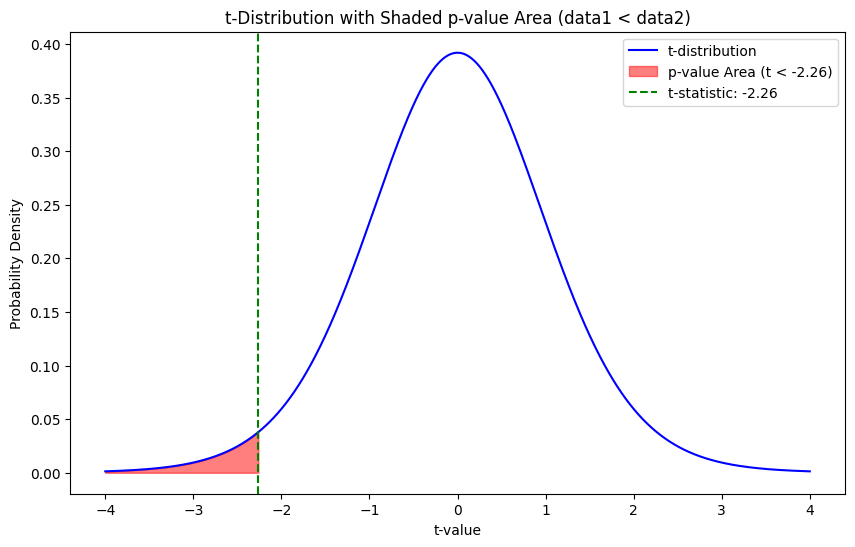

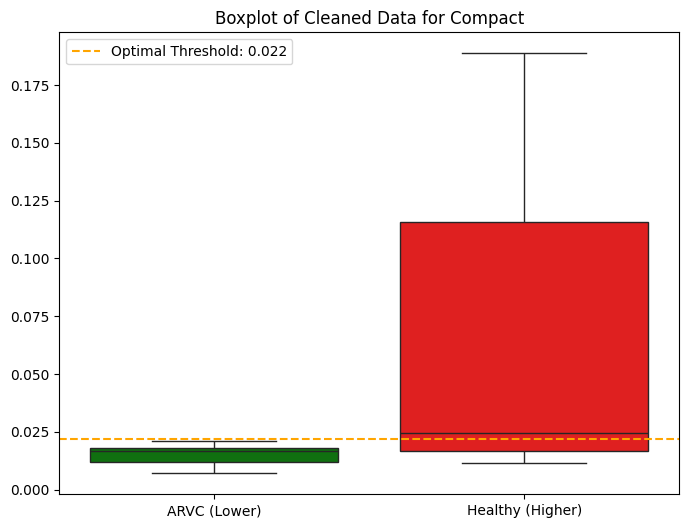

(-2.260612705719152, 0.02657500121601118, True)

In [22]:
area_positive = positive_data_T["Compact"].values
area_negative = negative_data_T["Compact"].values

print("Compact positive:", area_positive)
print("Compact negative:", area_negative)

optimal_threshold, _, _, _ = determine_optimal_threshold(area_positive, area_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"))


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(area_positive, area_negative, name="Compact", hypothesis="data2_greater", labels=("ARVC", "Healthy"), threshold=optimal_threshold)

